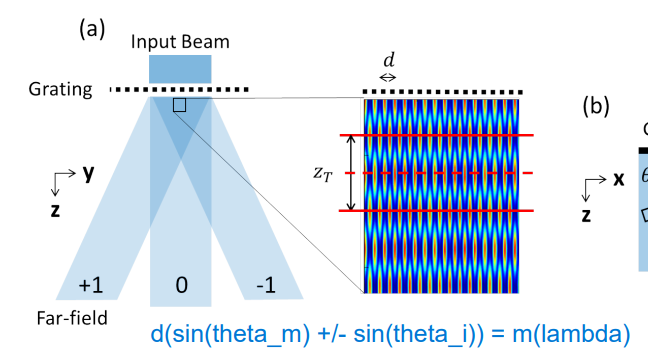

# Model of Imager

Prof. Keathley mentioned that, instead of doing the entire diffractive optics simulation of the grating like we did with WPM or using something like rigorous coupled wave analysis, we can expect the output to be dominated by the 0th, and 1st order diffracted beams, and if the input is close enough to a plane wave, approximate the output as a sum of three plane waves. This has the functional form:

$$I(x,z)\propto A_0^2 + A_1^2 + A_{-1}^2 + 2A_1A_{-1}\cos(4\pi x/d) + 2A_0(A_1+A_{-1})\cos(2\pi x/d)\cos(2\pi z/z_T) + 2A_0(A_1-A_{-1})\sin(2\pi x/d)\sin(2\pi z/z_T)$$

Depending on our sensor tilt and pixel pitch and size, we integrate over a certain $x$ and $z$ range of this pattern when we read out the intensity. I don't care about normalization in this process; we just want to see what the pattern looks like.

In [417]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

# length units in microns
wavelen = 0.75
gratinglen = 1.2

samplelen = 0.138 * 2 # CHANGE THIS TO CHANGE SIZE OF PIXELS
samples_per_pixel = 5 # product with samplelen is the micron pixel pitch, get samples_per_pixel^2 samples per pixel

z_T = wavelen / (1 - np.sqrt(1 - (wavelen**2 / gratinglen**2)))
print(z_T)

nxpix = 3496
nypix = 4656

# relative amplitudes
A0 = 1.0
A1 = 0.5
A_1 = 0.4

# factors in I(x,z) (note I ignore the A_0^2 + A_1^2 + A_-1^2 term that only contributes to the zero frequency)
factor1 = 2 * A1 * A_1
factor2 = 2*A0*(A1+A_1)
factor3 = 2*A0*(A1-A_1)

# angle of sensor
theta = 20 * np.pi/180

# (erroneous) rotation of sensor
phi = 1 * np.pi/180

3.418799519615616


We're going to compute $I(x,z)$ on the sensor plane, sampling a number of points per pixel of the sensor and averaging them. Our geometry is as follows: The grating sits in the $x-y$ plane. At zero angle, the sensor also sits in the $x-y$ plane. As we increase angle, the sensor is tilted around the $x$-axis. One edge of the sensor remains in contact with the grating at the $x$-axis. As a result, the range of $x$ values sampled is always the same, but the $z$ value goes as

$$z_{px} = y_{0,px}\sin(\theta)$$

where $y_{0,px}$ is the original (untilted) $y$ coordinate of the pixel.

In [418]:
def DoRotation(xx, yy, phi=0):
    """Rotate meshgrid arrays by phi radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(phi),  np.sin(phi)],
                          [-np.sin(phi), np.cos(phi)]])

    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([xx, yy]))

# Initialize the positions of samples with zero tilt
nsx = nxpix * samples_per_pixel
nsy = nypix * samples_per_pixel

xvals = np.linspace(0, nsx * samplelen, nsx)
yvals = np.linspace(0, nsy * samplelen, nsy)
xx, yy = np.meshgrid(xvals, yvals)

# perform a rotation of the sensor around z (an example imperfection)
xx, yy = DoRotation(xx, yy, phi)

# perform the tilt of the sensor around x
zz = yy * np.sin(theta)

In [419]:
# At each of the sampled points, compute I(x,z)
I = factor1 * np.cos(4*np.pi*xx / gratinglen) + factor2 * np.cos(2*np.pi*xx / gratinglen) * np.cos(2*np.pi*zz / z_T) + factor3 * np.sin(2*np.pi*xx / gratinglen) * np.sin(2*np.pi*zz / z_T)
# Downsample back into nxpix by nypix by sum
sum_I = skimage.measure.block_reduce(I, (samples_per_pixel, samples_per_pixel), np.sum)

In [412]:
#fig, ax = plt.subplots(figsize=(12,12), dpi=300)
#ax.matshow(sum_I[:, 0:1])
#ax.matshow(sum_I)
#plt.show()

# Fourier Transform of Overall Image

In [413]:
#ftim = np.fft.fft2(sum_I)
#fig, ax = plt.subplots(figsize=(12,12), dpi=150)
# crop into the non-negative frequencies
#cropftimage = ftim[0:ftim.shape[0]//2, 0:ftim.shape[1]//2]

### Plot FFT
#ax.imshow(np.abs(cropftimage))
#plt.show()

# Column-wise Fourier Transforms
This is what's used in the paper to estimate frequencies. Our rows (indexed along first dimension) are in the x-direction, in-plane to the grating. The columns (second dimension) represent the z-direction as sampled by the tilted sensor.

Recall that in this non-paraxial limit, with $\lambda\approx d$ of the grating, we have

$$z_T = \frac{\lambda}{1-\sqrt{1-\frac{\lambda^2}{d^2}}}$$

(4656, 3496)


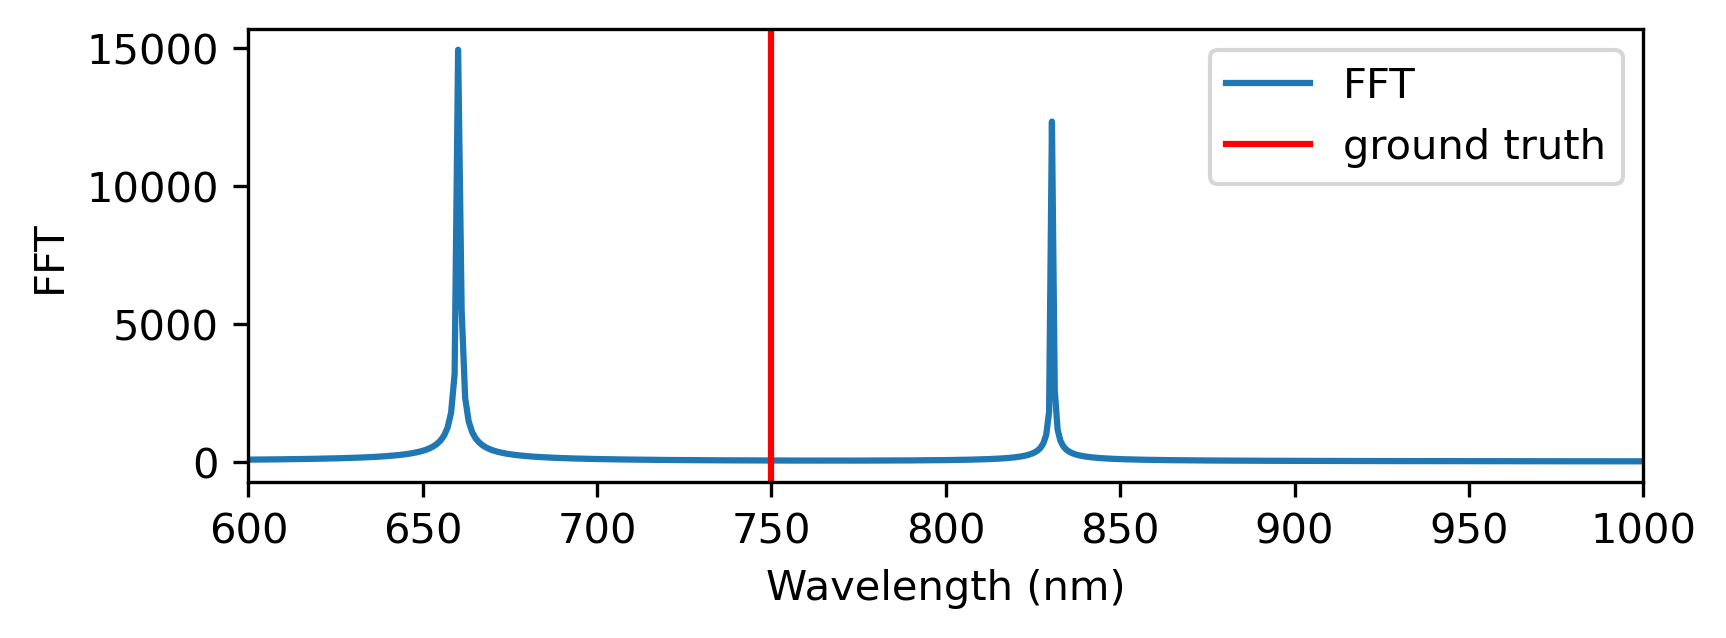

In [420]:
# Compute the FFT per column
FFT = np.zeros(sum_I.shape[0])
print(sum_I.shape)
for i in range(sum_I.shape[1]):
    signal = sum_I[:, i]
    fft = np.fft.fft(signal)
    FFT = FFT + fft
    
sampling_period = samplelen * samples_per_pixel * np.sin(theta)
frequencies = np.fft.fftfreq(FFT.shape[0], sampling_period) # spatial frequency in 1/microns of the Talbot pattern
Talbot_lengths = 1 / frequencies[1:]

# Convert spatial frequency into wavelength of incident light
wavelengths = 2 * Talbot_lengths * gratinglen**2 / (Talbot_lengths**2 + gratinglen**2)

result = np.abs(FFT)[1:sum_I.shape[0]//2]
plt.figure(figsize=(6,2), dpi=300)
plt.plot(wavelengths[:sum_I.shape[0]//2 - 1] * 1000, result, label='FFT')
plt.xlim((600, 1000))
plt.axvline(wavelen * 1000, color='red', label='ground truth')
plt.xlabel("Wavelength (nm)")
plt.ylabel("FFT")
plt.legend()
plt.show()